In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('../data_exploration/housing.csv')

In [3]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


Preprocessing with pipelines

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
df = df[df['total_rooms']<11333]

In [6]:
target = 'median_house_value'
y = df[target]
X = df.drop(columns=target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [8]:
class Features():
    def fit(self, df, y):
        self.df = df
        self.y = y
        return self
    
    def transform(self, df):
        df2 = df.copy()
        df2['house_by_pop'] = df["households"]/df["population"]
        df2['rooms_by_pop'] = df["total_rooms"]/df["population"]
        # df2['rooms_by_houses'] = df["total_rooms"]/df["households"]
        # Combining longitude and latitude
        df2['ll'] = df['longitude'] + df['latitude']

        return df2
        

In [9]:
class My_hot_encoding():
    def fit(self, df, y):
        self.df = df
        self.y = y
        return self
    
    def transform(self, df):
        df2 = pd.concat([df,pd.get_dummies(df['ocean_proximity'], drop_first=True)],axis='columns')
        
        return df2[['housing_median_age', 'total_rooms', 'median_income', 'house_by_pop',
                    'rooms_by_pop', 'll', 'INLAND', 'NEAR BAY', 'NEAR OCEAN']]

In [10]:
class Drop_outliers():
    def __init__(self):
        self.max_threshold_tr = 11333
        self.max_threshold_rp = 4
    
    def fit(self, df, y):
        self.df = df
        self.y = y
        return self
    
    def transform(self, df):
        return df[(df['total_rooms']<self.max_threshold_tr) & 
                  (df['house_by_pop']<self.max_threshold_rp)]

In [11]:
test = Pipeline(steps=[
    ('new_features', Features()),
    ('hot_encoding', My_hot_encoding()),
    ('normal', StandardScaler())
])

In [12]:
test.fit(X_train)

Pipeline(steps=[('new_features', <__main__.Features object at 0x7f909c09cc10>),
                ('hot_encoding',
                 <__main__.My_hot_encoding object at 0x7f909c09c400>),
                ('normal', StandardScaler())])

In [13]:
pp_X_train = test.transform(X_train)
pp_X_test = test.transform(X_test)

In [14]:
pp_X_train.shape

(16351, 9)

In [15]:
pp_X_test.shape

(4088, 9)

### Modeling

In [26]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import cross_val_score

In [43]:
cross_val_score(DecisionTreeRegressor(), pp_X_train, y_train).mean()

0.5782437821474169

In [28]:
cross_val_score(RandomForestRegressor(), pp_X_train, y_train).mean()

0.7851729720831807

In [30]:
cross_val_score(LinearRegression(), pp_X_train, y_train).mean()

0.6703137128156686

In [33]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [55]:
model_params = {
    'RandomForestRegressor': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [10,100,200],
        }
    },
     'DecisionTreeRegressor': {
         'model': DecisionTreeRegressor(),
         'params': {
             'max_depth': [5,7,10,20,50,100,150]
         }
     },
     'LinearRegression': {
         'model': LinearRegression(),
         'params': {}
     }
 
}

In [56]:
scores = []

for model_name, mp in model_params.items():
    mod =  GridSearchCV(mp['model'], mp['params'], cv=5)
    mod.fit(pp_X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': mod.best_score_,
        'best_params': mod.best_params_
    })
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,RandomForestRegressor,0.785833,{'n_estimators': 200}
1,DecisionTreeRegressor,0.704173,{'max_depth': 7}
2,LinearRegression,0.670314,{}


In [57]:
scores = []

for model_name, mp in model_params.items():
    mod =  RandomizedSearchCV(mp['model'], mp['params'], cv=5)
    mod.fit(pp_X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': mod.best_score_,
        'best_params': mod.best_params_
    })
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

/Users/noakawa/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/noakawa/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/noakawa/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


,model,best_score,best_params
0,RandomForestRegressor,0.785929,{'n_estimators': 200}
1,DecisionTreeRegressor,0.704990,{'max_depth': 7}
2,LinearRegression,0.670314,{}


In [69]:
mod_rf = RandomForestRegressor(n_estimators= 100)
mod_dt = DecisionTreeRegressor(max_depth=7)
mod_lr = LinearRegression()

In [70]:
mod_rf.fit(pp_X_train,y_train)
mod_dt.fit(pp_X_train,y_train)
mod_lr.fit(pp_X_train,y_train)

LinearRegression()

In [71]:
print(mod_rf.score(pp_X_test,y_test))
print(mod_dt.score(pp_X_test,y_test))
print(mod_lr.score(pp_X_test,y_test))

0.7911777450501508
0.7163214652758969
0.6734563914269631


In [65]:
import matplotlib.pyplot as plt

In [76]:
# Tuning Random Forest Regressor
scores_train = []
scores_test = []
estimators = np.arange(10,100,10)

for e in estimators:
    model = RandomForestRegressor(n_estimators = e)
    model.fit(pp_X_train,y_train)
    scores_train.append(model.score(pp_X_train,y_train))
    scores_test.append(model.score(pp_X_test,y_test))

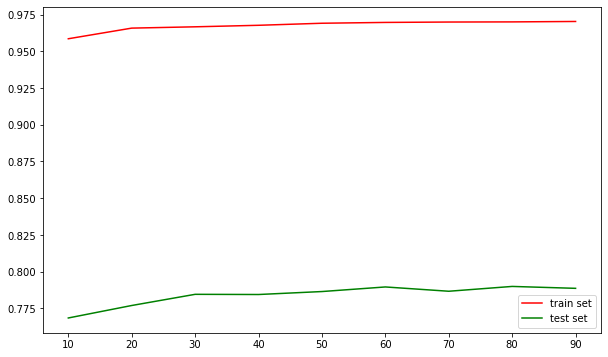

In [77]:
plt.figure(figsize=(10,6))
plt.plot(estimators,scores_train,color='r', label='train set')
plt.plot(estimators,scores_test,color='g', label='test set')
plt.legend()